# Exploratory Analysis

In [1]:
# imports and setup 
import pandas as pd
import scipy as sc
import numpy as np
import statsmodels.formula.api as sm
from ast import literal_eval

#%matplotlib notebook
import matplotlib.pyplot as plt 
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10, 6) 

Before proceeding with the main analysis and training portions of the project it is important to explore the dataset.
The dataset we collected contained a total of (blank) number of songs. Once those songs were restricted to only English and non-Instrumental tracks, we were left with (blank) total data points. Here is a sample of some of the data set.

In [2]:
data = pd.read_csv("english_clean.csv")
data[0:5]

,title,artist,lyrics,listens,hotness,genres,genius ID,spotify ID,language,instrumental,song length
0,Fast Cars,Craig David,"['Fast cars', 'Fast women', 'Speed bikes with ...",751624,28,"['r&b', 'rock']",NaN,NaN,en,False,379
1,Watching The Rain,Scapegoat Wax,"['Ya ya ya ya ya ya ya', 'Hello hello its me a...",10681,6,['pop'],NaN,NaN,en,False,360
2,Run to the Money,Bankroll Fresh,"['Fuckin up money I already done it', 'Guess w...",160202,17,['rap'],NaN,NaN,en,False,422
3,Determined (Vows of Vengeance) - Live at Summe...,Kataklysm,"['Your fate is made of words that you spill', ...",19218,4,['pop'],NaN,NaN,en,False,258
4,Dandelion Days,Adam McHeffey,"['Well look back on our old ways', 'And call t...",1038,0,['pop'],NaN,NaN,en,False,181


Each of the tracks contains 10 features: the title and artist, which aren’t particularly interesting to our purposes, the Spotify popularity metrics (hotness and number of listens), the platform IDs, genres, and finally the language and instrumental tags. We'll start with pandas describe tool and scatter_matrix method to get some generalities.

In [3]:
data[['listens','hotness','song length']].describe()

,listens,hotness,song length
count,8.582900e+04,85829.000000,85829.000000
mean,3.142271e+06,13.840089,253.660173
std,2.913977e+07,14.353226,181.912101
min,0.000000e+00,0.000000,0.000000
25%,9.261000e+03,2.000000,142.000000
50%,6.530500e+04,9.000000,212.000000
75%,4.165180e+05,22.000000,314.000000
max,1.420438e+09,91.000000,9969.000000


While spotify said that 100 is the maximum value for their hotness metric, the largest value in our dataset was 91. Whether any songs do actually reach 100 on that scale is unknown. The number of listens has a very large range, from zero to over a billion. Also notable is the change between the 75th percentile and the maximum. Such a large change suggests that very few songs actually reach those outrageous numbers.

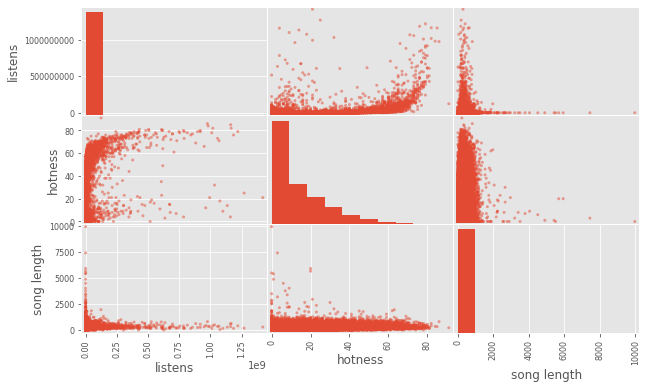

In [4]:
pd.plotting.scatter_matrix(data[['listens','hotness','song length']])
plt.show()

Unfortunately, there aren't many relationships revealed by the scatter matrix. Now, let’s look at the distributions of each of these variables.
First, let's look at the distribution of our listens metric, since this will be our main label for our training stages.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001B3C9C07CC8>]],
      dtype=object)

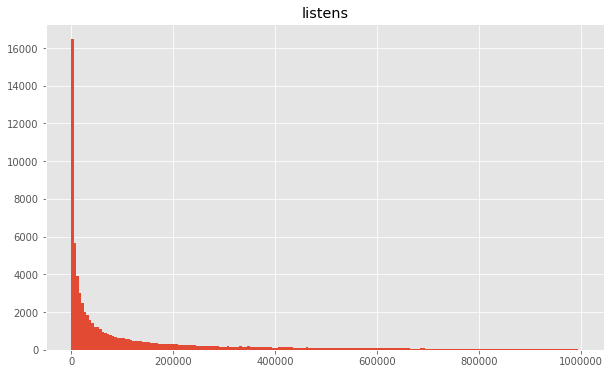

In [5]:
data.hist(column = "listens", bins = np.arange(0,1000000, 5000))

Looks like there is a heavy skew in the data. As one might expect, most songs are not popular. Only very few break away from the low thousands of listens. Also interesting to note is that the distribution is monomodal, and there are no identifiable groups. Let's look at the hotness metric to see if it follows a similar trend.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001B3CB590A48>]],
      dtype=object)

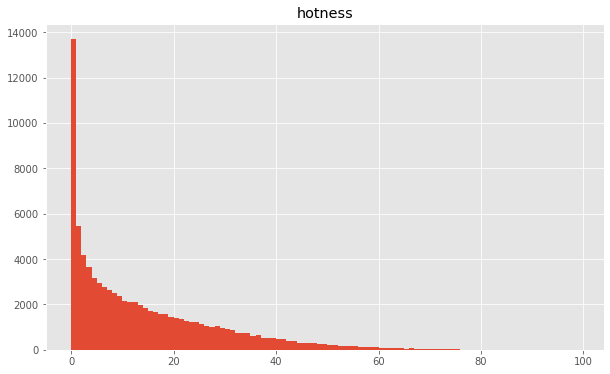

In [6]:
data.hist(column = "hotness", bins = np.arange(0,100, 1))

While we see a similar pattern in the hotness, there is far more spread than the number of listens. Once we pass the zero listens mark, the distribution plumets, whereas the hotness contains more mid-range data. Lets compare the spreads of the normalized versions for these two metrics. I've included song length as well, for comparison.

In [7]:
def normalize(item, maximum):
    return item / maximum

In [8]:
for metric in ['listens','hotness','song length']:
    normal = data[metric].apply(normalize, maximum = data[metric].max())
    variance = normal.var()
    print('The variance for normalized ' + metric + ' is: ' + str(variance))

The variance for normalized listens is: 0.00042085057180832986
The variance for normalized hotness is: 0.02487804643771043
The variance for normalized song length is: 0.0003329814081972538


Unsurprisingly, the dispersion is far higher in the hotness. But what's striking is that it is greater by many orders of magnitude. While at first glance these distributions may look very similar, they are in fact quite different. We suspect this may be indicative of a lack of correlation between the two measures. For referance, here is the song length distribution.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001B3CB724748>]],
      dtype=object)

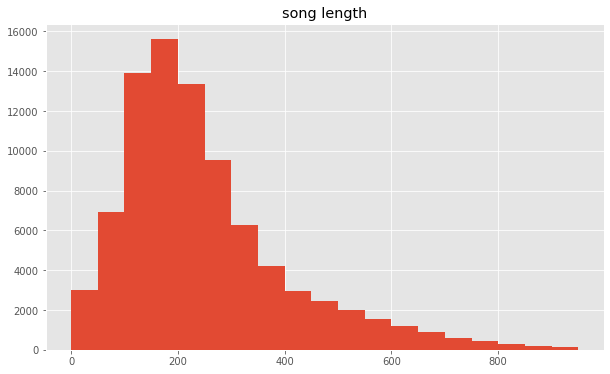

In [9]:
data.hist(column = "song length", bins = np.arange(0,1000, 50))

Since we suspect that the hotness and the number of listens are not correlated, let's explore a linear model relating the two metrics.

In [10]:
model = sm.ols(formula="hotness ~ listens", data=data).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                hotness   R-squared:                       0.071
Model:                            OLS   Adj. R-squared:                  0.071
Method:                 Least Squares   F-statistic:                     6543.
Date:                Sun, 29 Mar 2020   Prob (F-statistic):               0.00
Time:                        20:04:13   Log-Likelihood:            -3.4728e+05
No. Observations:               85829   AIC:                         6.946e+05
Df Residuals:                   85827   BIC:                         6.946e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     13.4282      0.047    282.699      0.0

Because the R^2 value is small, we have comfirmed our assumption that hotness and listens don't correlate very well. To visualize this, lets overlay the regression line against their scatter plot.

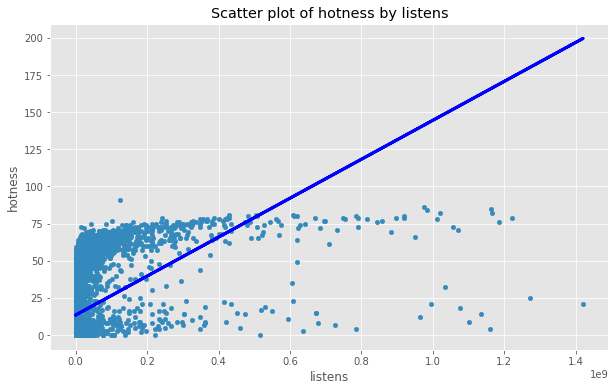

In [11]:
data.plot.scatter(x = "listens", y = "hotness",  title = "Scatter plot of hotness by listens")
plt.plot(data["listens"],model.predict(),color='blue',linewidth=3)

And of course, the model is absolutely terrible. Looking at the scatter plot, there seems to be very little relation between the metrics, and it is hard to imagine a model that would be successful given this data.

Now we will create a bar graph representing the most often used words within these songs. To do this, first we will create a blank dictionary to keep in these unique words. Then we will create a for loop and use and if and else statement, for when there's a repeating word or a new word. If it is new, then it's key is 1. If it is repeating, whatever key it was assigned to will increase by 1. Thus it tallies up all the uses.

In [12]:
data['lyrics'] = data['lyrics'].apply(literal_eval)
word_frequency = {}
for text in data["lyrics"]:
    for line in text:
        for word in line.lower().split(" "):
            if not word in word_frequency.keys() and not word == '':
                word_frequency.update({word: 1})
            else:
                if not word == '':
                    word_frequency[word] = word_frequency[word] + 1

Now we will create a series that contains the top 10 most used words from the index lookup. Before we do that, we will use the sorted funciton to sort out the words by use.

In [13]:
high_frequency_words = sorted(word_frequency, key = word_frequency.get, reverse = True)
print(high_frequency_words[:100])

['the', 'i', 'you', 'to', 'and', 'a', 'me', 'my', 'in', 'it', 'of', 'im', 'that', 'on', 'your', 'all', 'is', 'we', 'for', 'be', 'dont', 'like', 'with', 'but', 'so', 'know', 'this', 'its', 'up', 'no', 'just', 'love', 'when', 'what', 'got', 'now', 'get', 'do', 'out', 'can', 'they', 'if', 'oh', 'go', 'down', 'yeah', 'was', 'are', 'time', 'never', 'see', 'youre', 'not', 'one', 'from', 'will', 'cant', 'she', 'have', 'back', 'want', 'at', 'come', 'make', 'say', 'let', 'take', 'way', 'aint', 'cause', 'baby', 'ill', 'as', 'were', 'how', 'life', 'her', 'he', 'feel', 'been', 'wanna', 'here', 'need', 'right', 'away', 'ive', 'there', 'where', 'more', 'thats', 'tell', 'by', 'man', 'our', 'could', 'well', 'gonna', 'day', 'night', 'or']


Looks like the high frequency words are very similar to the high frequency words in standard use.

Lets also explore the genres within the dataset. First, we'll create a dictionary of frequency of appearance for each genre.

In [14]:
data['genres'] = data['genres'].apply(literal_eval)
genre_list = {}
for genres in data["genres"]:
    for genre in genres:
        if not genre in genre_list:
            genre_list[genre] = 1
        else:
            genre_list[genre] = genre_list[genre] + 1

Here are the total number of unique genres found.

In [15]:
len(genre_list)

657

Lets now plot the frequencies of the top ten most popular genres.

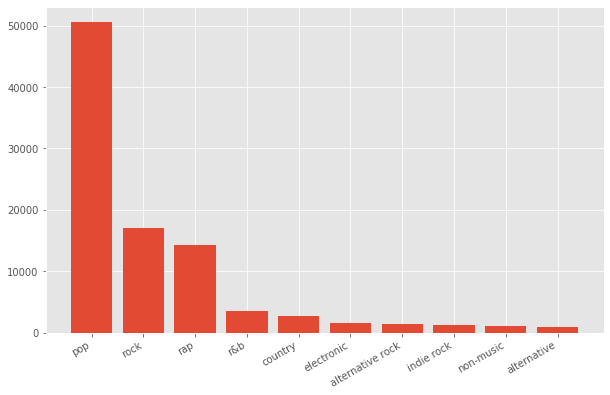

In [16]:
number_of_songs, top_genres = zip(*sorted((songs, genre) for (genre, songs) in genre_list.items())[-10:])
fig, ax = plt.subplots()
ax.bar(top_genres[::-1], number_of_songs[::-1])
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.show()

Here we see that the most popular genres of music are Pop, Rock, and Rap, by a significant margin. Followed by r&b and country. Interestingly, there are enough songs with the genre 'non-music' to appear in the top ten. Lets take a look at what some of those songs look like.

In [17]:
non_music = [('non-music' in genres) for genres in data['genres']]
data[non_music]

,title,artist,lyrics,listens,hotness,genres,genius ID,spotify ID,language,instrumental,song length
73,Microwave Light,Beagles,"[Michaels dog eyes look at microwave light, Mi...",50880,15,[non-music],NaN,NaN,en,False,109
207,Journey,Klaypex,[],240523,16,[non-music],2872011.0,3Tt4U8VAu4UjDJwXKbargs,en,False,0
280,Float Away,Kimberly Freeman,"[Speckles on the ceiling, Im sure glad it does...",4544,1,"[non-music, news]",106181.0,1o9aI7n3bncVl6r9UuXsaT,en,False,163
392,Remember,Christina Rossetti,"[Remember me when I am gone away, Gone far awa...",0,0,"[non-music, literature]",148716.0,1U9RRj1ecncuqtJ4mfmEq4,en,False,111
424,There Was A Young Lady Whose Eyes,Edward Lear,"[There was a young lady whose eyes, were uniqu...",0,0,"[non-music, literature]",184622.0,142pGVj40vNHSNH2viUIYk,en,False,28
...,...,...,...,...,...,...,...,...,...,...,...
85183,Hard Time,Lance Lopez,"[You got the needle, I got the dime, You press...",62812,15,"[non-music, blues]",3004350.0,0ij3htkMBTH6E1CM14K0i6,en,False,276
85214,Underground,WebsterX,"[Intro Mumble, Been around, round my town, bee...",72208,10,[non-music],3038290.0,19TvBu2850xb47dvW2V5Ex,en,False,482
85342,Forever Settled (feat. Dorinda Clark-Cole),Jonathan Nelson,[Come to pass tell somebody I got a word and i...,94681,11,"[non-music, gospel]",2908440.0,1RTVYnSjS3dOqMDT56MSqm,en,False,665
85489,In / Balance,San Scout,"[My pride self loathing, Im on track to not kn...",2920552,36,"[indie pop, electronic, non-music]",2925747.0,787wgtjKgWEITw2RNI2Hi8,en,False,158


It appears that the tag non-music is used for when certain portions of the track (possibly the entire thing) contain spoken word which is not accompanied by instruments or sung. This does not mean, however, that the entire track is non-musical, so these are still appropriate for our dataset.

That concludes the extent of the exploratory analysis required for our project.